## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Calculate the camera calibration coeffients

In [4]:
print(gray.shape[::-1])

(1280, 720)


In [5]:
ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None) 

## Undistort images

In [20]:
def undistort_img(img, mtx, dist):
    return cv2.undistort(img,mtx,dist,None,mtx)

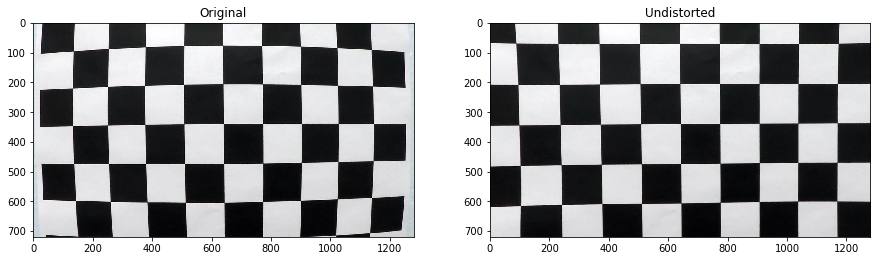

In [26]:
# test chessboard image undistortion
CB__test = cv2.imread('./camera_cal/calibration1.jpg')
undistorted_CB_test = undistort_img(CB__test, mtx, dist)

# display original and undistorted chessboard images
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
ax1.imshow(CB__test)
ax1.set_title('Original')
ax2.imshow(undistorted_CB_test)
ax2.set_title('Undistorted')

In [192]:
test_imgs1_path = glob.glob('./test_images/test*.jpg')
test_imgs2_path = glob.glob('./test_images/straight_lines*.jpg')
test_imgs_path = test_imgs1_path + test_imgs2_path
test_imgs = []
for i in range(len(test_imgs_path)):
    img = cv2.imread(test_imgs_path[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    test_imgs.append(img)

In [195]:
# show example 
import random
# generate random example imgages' ids
test_ids = random.sample(range(len(test_imgs)),4)
test_images = []
for img_id in test_ids:
    test_images.append(test_imgs[img_id])

# Undistort example images
undistorted_test_images = []
for img in test_images:
    image = img
    undistorted_test_images.append(undistort_img(image,mtx,dist))
    
rows = 4
cols = 2

def showImgs(imgs, processed_imgs, rows, cols, cmap = None, title = ''):
    fig, axes = plt.subplots(rows, cols, figsize=(15,10))
    axes = axes.ravel()
    axes[0].set_title('Original')
    axes[1].set_title(title)
    for j in range(0,rows):
        img_index = j
        # plot original images in the odd number col and undistorted images in the even number col
        for i in range(cols):
            mod_i = i%cols
            index_ = j*cols + mod_i
            if mod_i == 0:
                image = imgs[img_index]
                #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                axes[index_].imshow(image, cmap=cmap)
            else:
                image = processed_imgs[img_index]
                axes[index_].imshow(image, cmap=cmap)


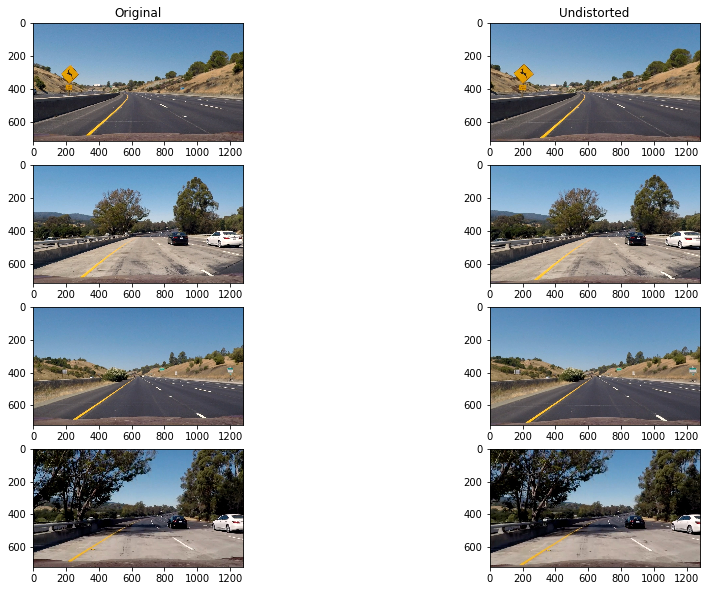

In [196]:
showImgs(test_images,undistorted_test_images, rows,cols, title = 'Undistorted')

## Apply gradients and color space transformation to create thresholded binary images

### Color space tranformation

In [259]:
# generate S-channel thresholded binary images in HLS 
def binary_S_thresholded(imgs, thresholds = (150,255)):
    binary_S = []
    for img in imgs:
        # obtain S-channel image
        hsl = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
        S = hsl[:,:,2]
        # generate a binary image mask
        binary_img = np.zeros_like(S)
        # apply thresholds
        binary_img[(S > thresholds[0]) & (S <= thresholds[1])] = 1
        binary_S.append(binary_img)
    return binary_S

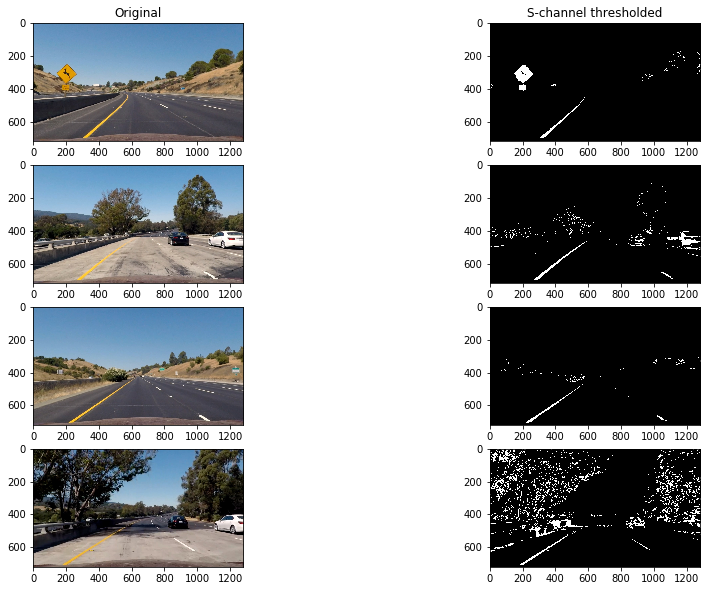

In [260]:
binary_S_imgs = binary_S_thresholded(undistorted_test_images)
showImgs(undistorted_test_images,binary_S_imgs, rows,cols, cmap = 'gray', title = 'S-channel thresholded')

### Gradient x and direction combining transformation

In [265]:
# generate gradient x and direction combining thresholded binary images
def binary_grad_x_dir_thresholded(imgs, thresholdsx = (25, 100), thresholdsdir = (0.7,1.2)):
    binary_outputs = []
    for img in imgs:
        # grayscale images
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # calculate absolute sobel x and sobel y
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = 3)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = 3)
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        # scale to an 8-bit range (0-255)
        scaled_sobelx = np.uint8(255 * abs_sobelx/np.max(abs_sobelx))
        scaled_sobely = np.uint8(255 * abs_sobely/np.max(abs_sobely))
        # calculate the direction of gradient
        dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
        # generate a binary mask
        binary_out = np.zeros_like(scaled_sobelx)
        binary_out[(scaled_sobelx > thresholdsx[0]) & (scaled_sobelx <= thresholdsx[1]) & \
                   (dir_gradient > thresholdsdir[0]) & (dir_gradient <= thresholdsdir[1]) ] = 1
        binary_outputs.append(binary_out)
    return binary_outputs

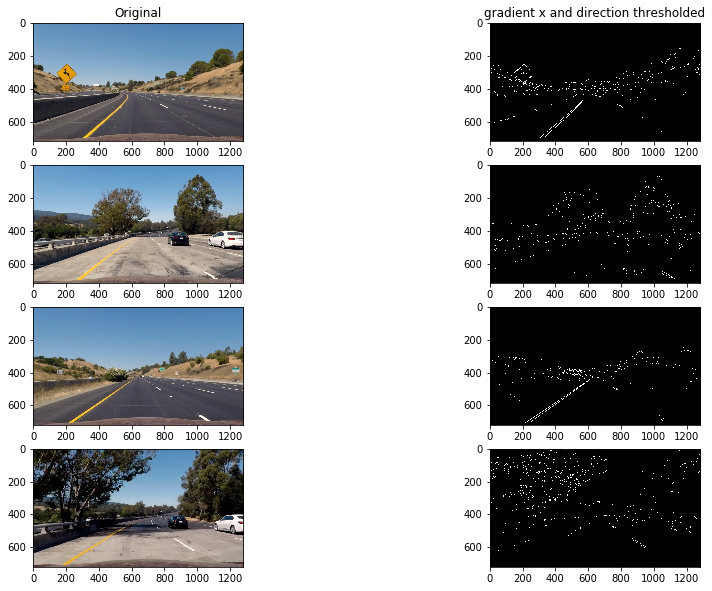

In [266]:
binary_x_dir_imgs = binary_grad_x_dir_thresholded(undistorted_test_images)
showImgs(undistorted_test_images,binary_x_dir_imgs, rows,cols, cmap = 'gray', title = 'gradient x and direction thresholded')

### Combining S-channel and gradient transformation

In [267]:
# combining different binary images
def comb_binary(binary_S, binary_grad):
    binary_comb = []
    for img_S, img_grad in zip(binary_S, binary_grad):
        binary_comb_img = np.zeros_like(img_S)
        binary_comb_img[(img_S == 1) | (img_grad == 1)] = 1
        binary_comb.append(binary_comb_img)
    return binary_comb

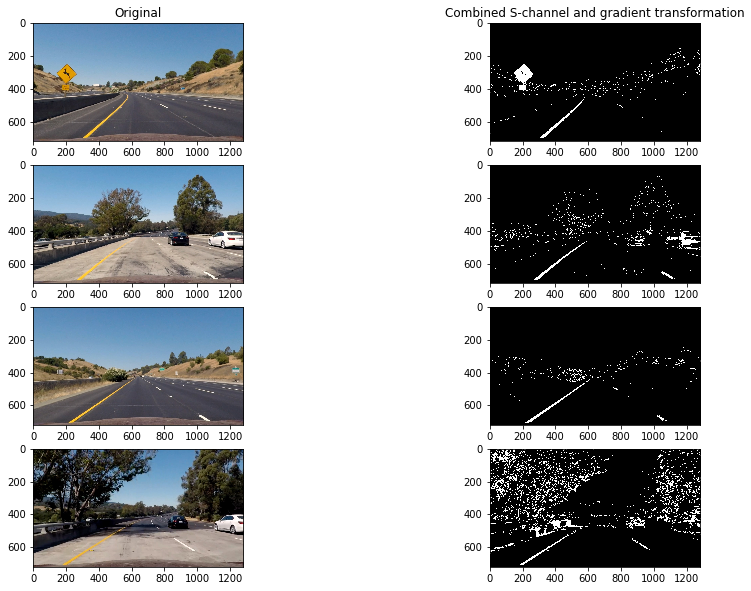

In [268]:
comb_binary_outputs = comb_binary(binary_S_imgs,binary_x_dir_imgs)
showImgs(undistorted_test_images,comb_binary_outputs, rows,cols, cmap = 'gray', title = 'Combined S-channel and gradient transformation')

## Apply perspective transform to binary images

In [269]:
# unwarp images using perspective transformation
def unwarp_imgs(imgs):
    unwarped_outputs = []
    for img in imgs:
        # grayscale image
        #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = (gray.shape[1], gray.shape[0])
        # define src and dst
        lt_pos = (585, 450) # left top position
        lb_pos = (190, 720) # left bottom position
        rt_pos = (700, 450) # right top position
        rb_pos = (1120, 720) # right bottom position
        
        src = np.float32([[lt_pos[0], lt_pos[1]], 
               [lb_pos[0], lb_pos[1]], 
               [rb_pos[0], rb_pos[1]], 
               [rt_pos[0], rt_pos[1]]])
        
        offset = 200
        dst = np.float32([[offset, 0],
               [offset, img_size[1]],
               [img_size[0]-offset, img_size[1]],
               [img_size[0]-offset, 0]])
        M = cv2.getPerspectiveTransform(src,dst)
        M_inv = cv2.getPerspectiveTransform(dst, src)
        unwarped_img = cv2.warpPerspective(img, M, img_size)
        #unwarped_img = cv2.cvtColor(unwarped_img,cv2.COLOR_BGR2RGB)
        unwarped_outputs.append(unwarped_img)
    return unwarped_outputs

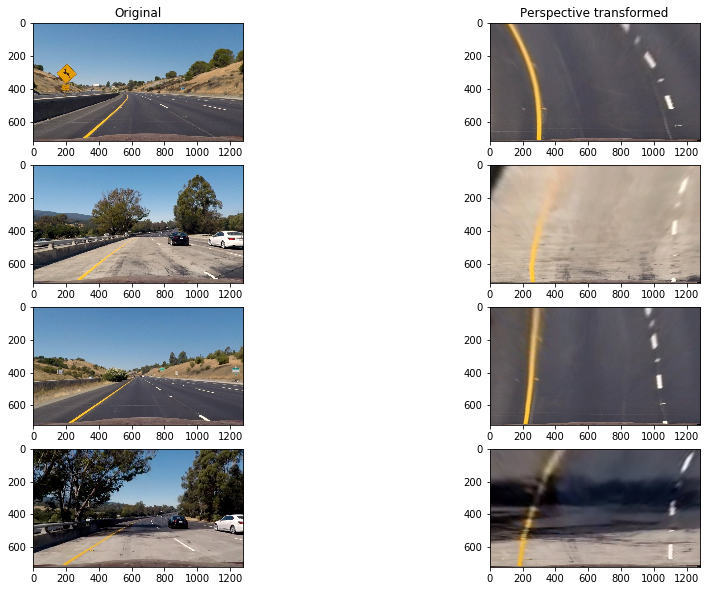

In [270]:
unwarped_imgs = unwarp_imgs(undistorted_test_images)
showImgs(undistorted_test_images,unwarped_imgs, rows,cols, cmap = 'gray', title = 'Perspective transformed')

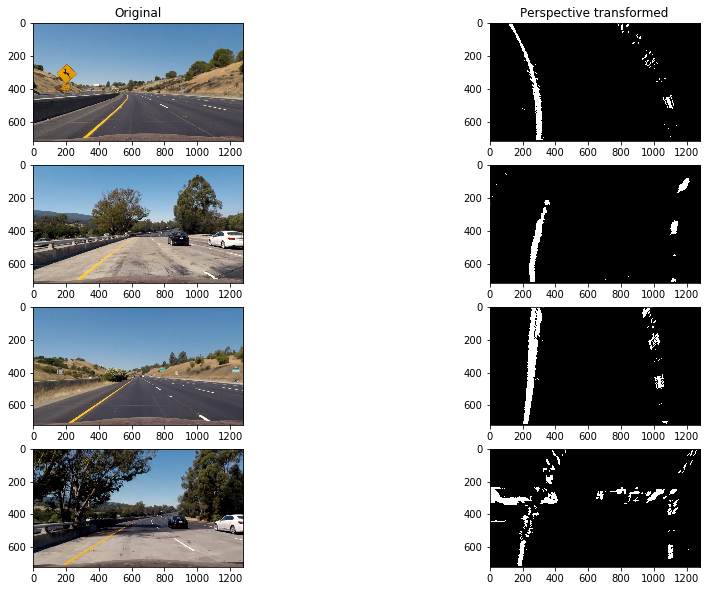

In [271]:
unwarped_imgs = unwarp_imgs(comb_binary_outputs)
showImgs(undistorted_test_images,unwarped_imgs, rows,cols, cmap = 'gray', title = 'Perspective transformed')